# Modeling

In [4]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

In [5]:
# Get the data
g_drive = "G:/My Drive/ADS-599_Cap_Stone/Capstone_data/"

X_test = pd.read_pickle(g_drive + "X_test" +".pkl") 
y_test = pd.read_pickle(g_drive + "y_test" +".pkl") 
# X_train = pd.read_pickle(g_drive + "X_train" +".pkl") 
# y_train = pd.read_pickle(g_drive + "y_train" +".pkl")
X_sm_train = pd.read_pickle(g_drive + "X_sm_train" +".pkl") 
y_sm_train = pd.read_pickle(g_drive + "y_sm_train" +".pkl")


In [27]:
# Helper function to get classification model results

def model_stats(model_name: str, grid_search, x: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
    predictions = grid_search.predict(x)
    cm = confusion_matrix(y, predictions)
    TN, FP, FN, TP = cm.flatten()
    data = {}
    data["Model"] = [model_name]
    data["Accuracy"] = [(TP + TN) / (TN + FP + FN + TP)]
    data["AUC"] = roc_auc_score(y, grid_search.predict_proba(x)[:,1])
    Precision = (TP / (TP + FP)) 
    data["Precision"] = Precision
    Recall = (TP / (TP + FN)) 
    data["Recall"] = Recall
    data["F1 Score"] = [(2 * Precision * Recall) / (Precision + Recall)] 

    return [pd.DataFrame(data), cm]

# Naive Bayes

In [72]:
# Naive Bayes

param_grid = {"alpha": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

nb_grid_search = GridSearchCV(MultinomialNB(), 
                              param_grid, 
                              cv=3,
                              return_train_score=True,
                              verbose=2,
                              n_jobs=-1,
                              scoring='roc_auc', # 'recall' # 'precision' # 'recall' # 'roc_auc' # 'accuracy'
                              error_score='raise'
                              )

# use sklearn.metrics.get_scorer_names() to get a list of all available scorers

nb_fit = nb_grid_search.fit(X_sm_train, y_sm_train)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3, error_score='raise', estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000, 10000]},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [69]:
print("Selected Hyperparameters:",nb_grid_search.best_params_)
print("Best Model Score:", nb_grid_search.best_score_)

list = model_stats("Naive Bayes", x = X_sm_train, y = y_sm_train)
list[0]

Selected Hyperparameters: {'alpha': 0.0001}
Best Model Score: 0.9957052578397735


,Model,Accuracy,AUC,Precision,Recall,F1 Score
0,Naive Bayes,0.979327,0.999166,0.994609,0.963878,0.631579


In [70]:
list = model_stats("Naive Bayes", x = X_test, y = y_test)
list[0]

,Model,Accuracy,AUC,Precision,Recall,F1 Score
0,Naive Bayes,0.976705,0.968733,0.773256,0.755682,0.631579


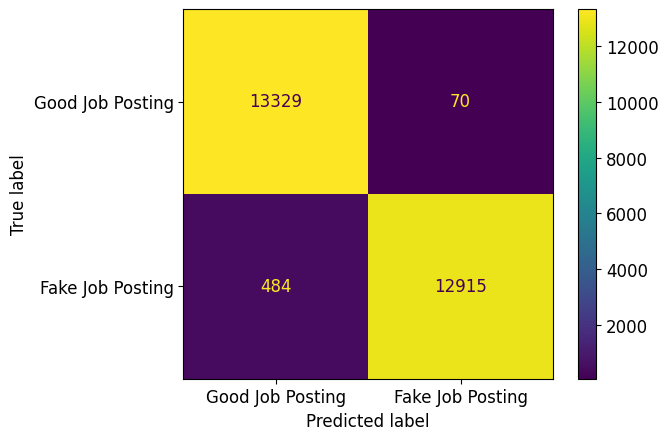

In [64]:
ConfusionMatrixDisplay.from_estimator(
    nb_grid_search,
    X_sm_train,
    y_sm_train,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

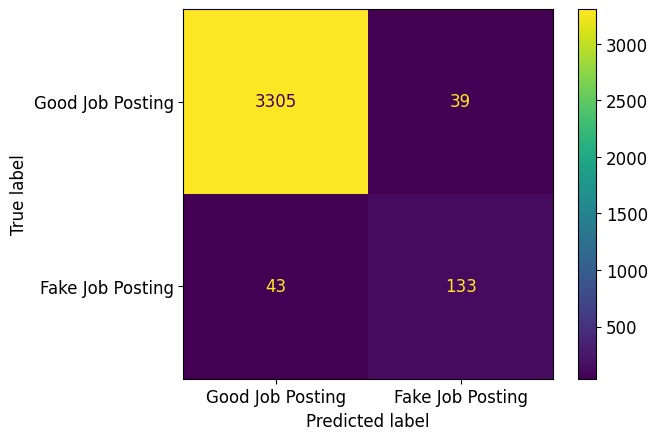

In [65]:
ConfusionMatrixDisplay.from_estimator(
    nb_grid_search,
    X_test,
    y_test,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

In [35]:
list[1]

array([[3195,  149],
       [  26,  150]], dtype=int64)

In [16]:
# Classification Report
print(
    classification_report(
        y_test,
        nb_grid_search.predict(X_test),
        target_names=["Good Job Posting", "Fake Job Posting"]
    )
)

                  precision    recall  f1-score   support

Good Job Posting       0.99      0.96      0.97      3344
Fake Job Posting       0.50      0.85      0.63       176

        accuracy                           0.95      3520
       macro avg       0.75      0.90      0.80      3520
    weighted avg       0.97      0.95      0.96      3520



In [38]:
from sklearn import metrics
auc = metrics.roc_auc_score(y_test, nb_grid_search.predict(X_test))
auc

0.9038576555023923

# Logistic Regression

In [5]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

lr_grid_search = GridSearchCV(estimator=model, 
                           param_grid=grid, 
                           n_jobs=-1, 
                           cv=3, # 3-fold cross-validation
                           scoring='roc_auc',
                           error_score=0)
# use sklearn.metrics.get_scorer_names() to get a list of all available scorers

lr_result = lr_grid_search.fit(X_sm_train, y_sm_train)


In [6]:
# summarize results
print("Best: %f using %s" % (lr_result.best_score_, lr_result.best_params_))
means = lr_result.cv_results_['mean_test_score']
stds = lr_result.cv_results_['std_test_score']
params = lr_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.999434 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.999433 (0.000474) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.999416 (0.000481) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.999434 (0.000473) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.999269 (0.000549) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.999266 (0.000549) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.999270 (0.000548) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.998290 (0.000853) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.998290 (0.000853) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.998296 (0.000851) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.989825 (0.002134) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.989825 (0.002134) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.989973 (0.002085) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.951890 (0.004123) wit

In [7]:
# Classification Report
print(
    classification_report(
        y_test,
        lr_result.predict(X_test),
        target_names=["Good Job Posting", "Fake Job Posting"]
    )
)

                  precision    recall  f1-score   support

Good Job Posting       0.99      0.99      0.99      3344
Fake Job Posting       0.80      0.88      0.84       176

        accuracy                           0.98      3520
       macro avg       0.90      0.93      0.91      3520
    weighted avg       0.98      0.98      0.98      3520



# XGBoost

In [5]:
# define models and parameters
# model = XGBClassifier(learning_rate=0.02, n_estimators=300)
model = XGBClassifier()
grid = {
        # 'min_child_weight': [1, 5, 10],
        # 'gamma': [0.5, 1, 1.5, 2, 5],
        # 'subsample': [0.6, 0.8, 1.0],
        # 'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3,4,5,10,20,40]
        }

xgb_grid_search = GridSearchCV(estimator=model, 
                               param_grid=grid, 
                               n_jobs=-1,
                               cv=3, # 3-fold cross-validation
                               scoring='roc_auc',
                               error_score='raise')
# use sklearn.metrics.get_scorer_names() to get a list of all available scorers

xgb_result = xgb_grid_search.fit(X_sm_train, y_sm_train)



C:\Users\zfreitas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
print("Average of the best ROC AUC in various folds during cross validation = ", xgb_result.best_score_)
print("The best parameters found during 3-fold cross validation is = ", xgb_result.best_params_)

In [ ]:
list = model_stats("xgBoost", x = X_sm_train, y = y_sm_train)
list[0]

In [ ]:
# Classification Report
print(
    classification_report(
        y_test,
        lr_result.predict(X_test),
        target_names=["Good Job Posting", "Fake Job Posting"]
    )
)

# LightGBM

In [7]:
# define models and parameters
model = LGBMClassifier()
grid = {
        }

gbm_grid_search = GridSearchCV(estimator=model, 
                               param_grid=grid, 
                               n_jobs=-1,
                               cv=3, # 3-fold cross-validation
                               scoring='roc_auc',
                               error_score='raise')
# use sklearn.metrics.get_scorer_names() to get a list of all available scorers

gbm_result = gbm_grid_search.fit(X_sm_train, y_sm_train)

LightGBMError: Do not support special JSON characters in feature name.

In [ ]:
print("Average of the best ROC AUC in various folds during cross validation = ", xgb_result.best_score_)
print("The best parameters found during 3-fold cross validation is = ", xgb_result.best_params_)

In [ ]:
list = model_stats("xgBoost", x = X_sm_train, y = y_sm_train)
list[0]

# Gradiant Boosting Machine for Classification

In [8]:
# define models and parameters
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10)
grid = {'max_depth':range(5,16,2), 
        'min_samples_split':range(200,1001,200)
        }

gbm_grid_search = GridSearchCV(estimator=model, 
                               param_grid=grid, 
                               n_jobs=-1,
                               cv=3, # 3-fold cross-validation
                               scoring='roc_auc',
                               error_score='raise')
# use sklearn.metrics.get_scorer_names() to get a list of all available scorers

gbm_result = gbm_grid_search.fit(X_sm_train, y_sm_train)

In [13]:
print("Average of the best ROC AUC in various folds during cross validation = ", gbm_result.best_score_)
print("The best parameters found during 3-fold cross validation is = ", gbm_result.best_params_)

Average of the best ROC AUC in various folds during cross validation =  0.9997043105056908
The best parameters found during 3-fold cross validation is =  {'max_depth': 15, 'min_samples_split': 200}


In [28]:
list = model_stats("GBM", gbm_grid_search, x = X_sm_train, y = y_sm_train)
list[0]

,Model,Accuracy,AUC,Precision,Recall,F1 Score
0,GBM,0.99903,0.999993,0.999328,0.998731,0.999029


In [31]:
list = model_stats("GBM", gbm_grid_search, x = X_test, y = y_test)
list[0]

,Model,Accuracy,AUC,Precision,Recall,F1 Score
0,Naive Bayes,0.980966,0.986174,0.834356,0.772727,0.80236


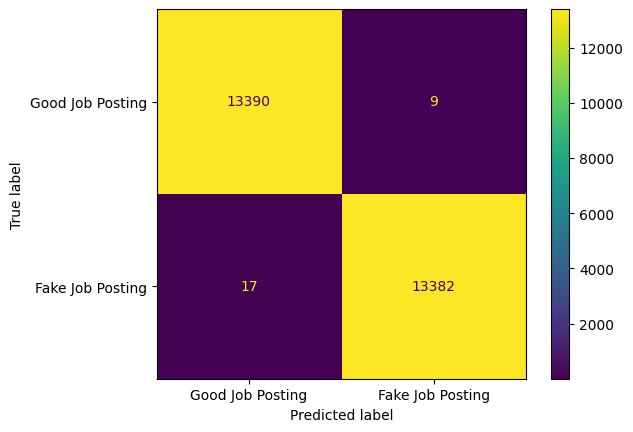

In [33]:
ConfusionMatrixDisplay.from_estimator(
    gbm_grid_search,
    X_sm_train,
    y_sm_train,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

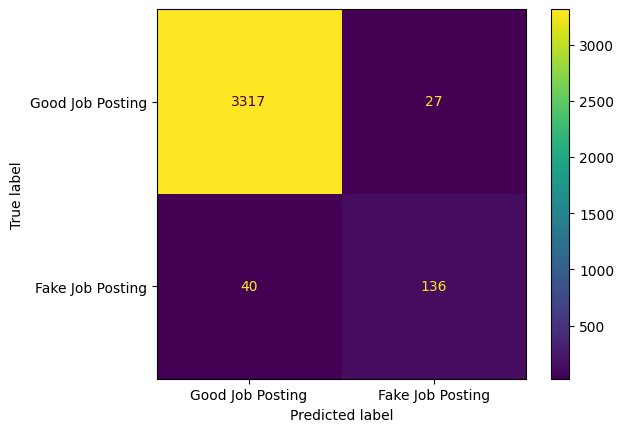

In [34]:
ConfusionMatrixDisplay.from_estimator(
    gbm_grid_search,
    X_test,
    y_test,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

In [29]:
# Classification Report
print(
    classification_report(
        y_test,
        gbm_result.predict(X_test),
        target_names=["Good Job Posting", "Fake Job Posting"]
    )
)

                  precision    recall  f1-score   support

Good Job Posting       0.99      0.99      0.99      3344
Fake Job Posting       0.83      0.77      0.80       176

        accuracy                           0.98      3520
       macro avg       0.91      0.88      0.90      3520
    weighted avg       0.98      0.98      0.98      3520



# Random Forest Classifier


from sklearn.ensemble import RandomForestClassifier

In [35]:
# define models and parameters
from sklearn.ensemble import GradientBoostingClassifier
model = RandomForestClassifier(n_estimators = 100)  
grid = {
        # 'bootstrap': [True, False],
        # 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        # 'max_features': ['auto', 'sqrt'],
        # 'min_samples_leaf': [1, 2, 4],
        # 'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
        }

rf_grid_search = GridSearchCV(estimator=model, 
                               param_grid=grid, 
                               n_jobs=-1,
                               cv=3, # 3-fold cross-validation
                               scoring='roc_auc',
                               error_score='raise')
# use sklearn.metrics.get_scorer_names() to get a list of all available scorers

rf_result = rf_grid_search.fit(X_sm_train, y_sm_train)

In [ ]:
print("Average of the best ROC AUC in various folds during cross validation = ", rf_result.best_score_)
print("The best parameters found during 3-fold cross validation is = ", rf_result.best_params_)

In [ ]:
list = model_stats("Random Forest", rf_grid_search, x = X_sm_train, y = y_sm_train)
list[0]

In [ ]:
list = model_stats("Random Forest", rf_grid_search, x = X_test, y = y_test)
list[0]

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    rf_grid_search,
    X_sm_train,
    y_sm_train,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    rf_grid_search,
    X_test,
    y_test,
    display_labels=["Good Job Posting", "Fake Job Posting"],
);

In [ ]:
# Classification Report
print(
    classification_report(
        y_test,
        rf_grid_search.predict(X_test),
        target_names=["Good Job Posting", "Fake Job Posting"]
    )
)